In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bambi.plots import plot_cap
from matplotlib.lines import Line2D

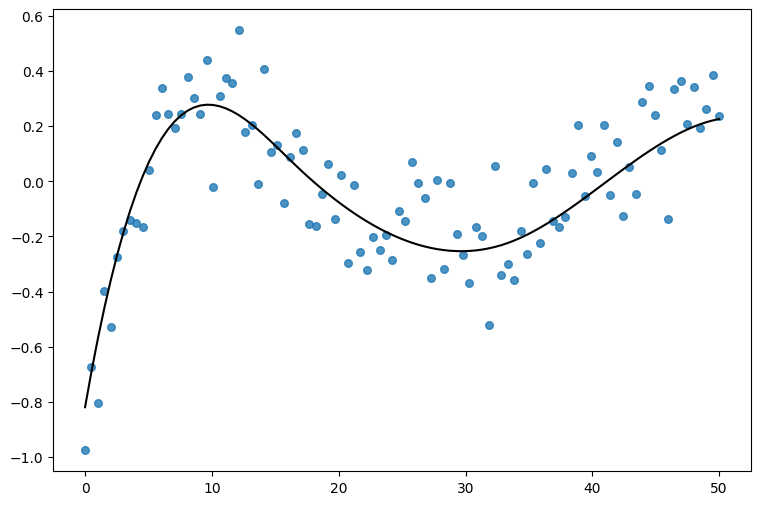

In [2]:
rng = np.random.default_rng(seed=121195)

N = 100
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=6)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=6, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [3]:
df = pd.DataFrame({"x": x, "y": y})
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}
priors = {
    "hsgp(x, m=10, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2, centered=True)", df, priors=priors)
model.set_alias({"hsgp(x, m=10, c=2, centered=True)": "hsgp"})
model

       Formula: y ~ 0 + hsgp(x, m=10, c=2, centered=True)
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, m=10, c=2, centered=True)
                cov: ExpQuad
                sigma ~ Exponential(lam: 2.0)
                ell ~ InverseGamma(mu: 10.0, sigma: 1.0)
        
        Auxiliary parameters
            y_sigma ~ HalfNormal(sigma: 10.0)

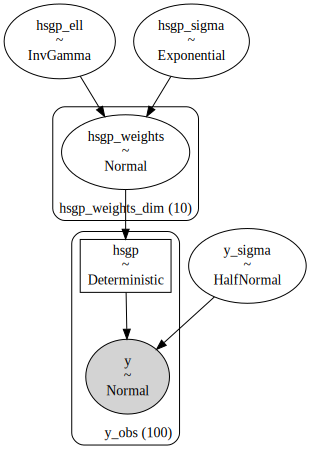

In [4]:
model.build()
model.graph()

In [5]:
idata = model.fit(inference_method="nuts_numpyro")
print(idata.sample_stats["diverging"].sum().to_numpy())

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.080110
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.701829
Transforming variables...
Transformation time =  0:00:00.072893
0


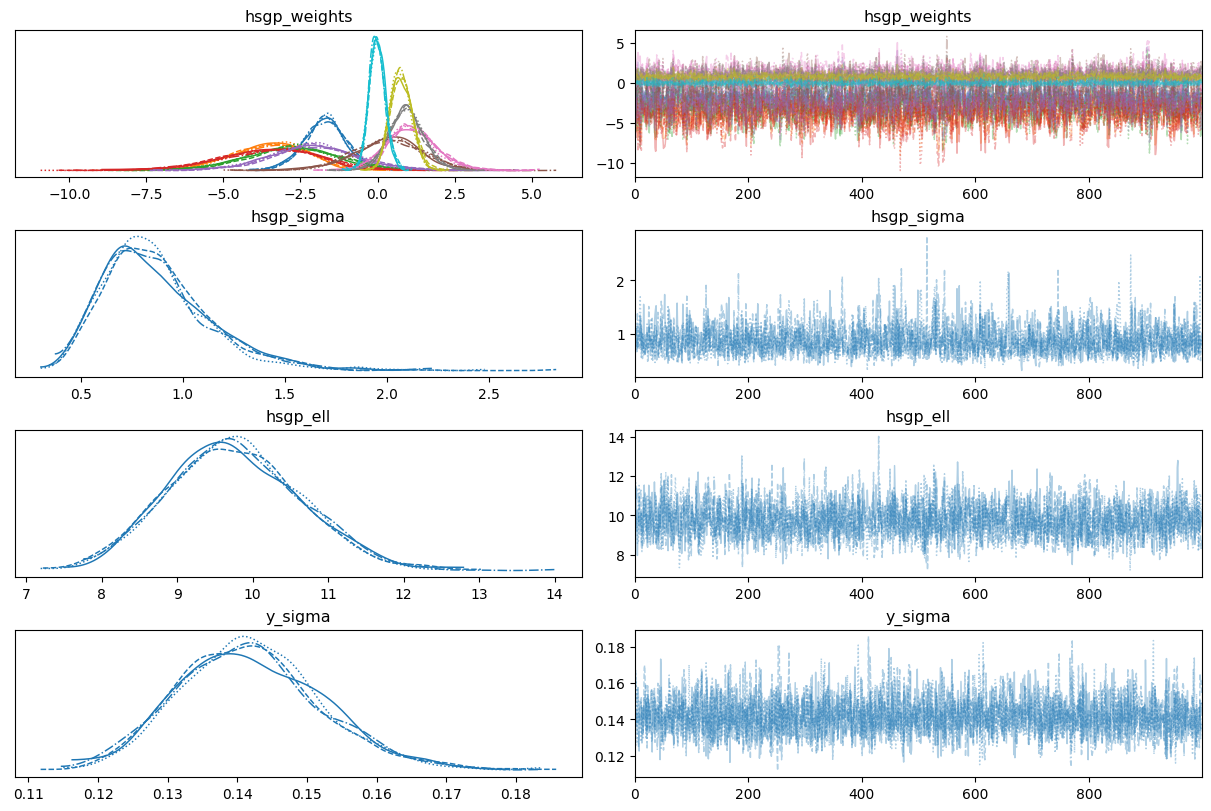

In [6]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

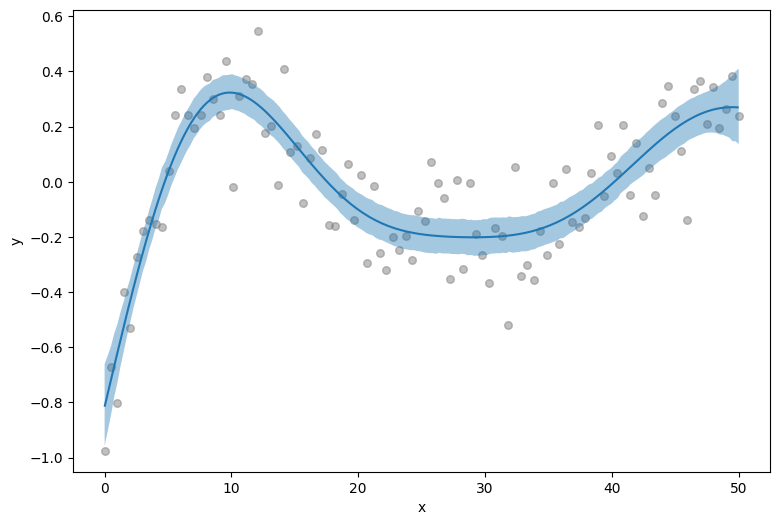

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5)
plot_cap(model, idata, "x", ax=ax);

In [8]:
new_data = pd.DataFrame({"x": np.linspace(0, 50, num=500)})
model.predict(idata, kind="pps", data=new_data)
pps = idata.posterior_predictive["y"].to_numpy().reshape(4000, 500)

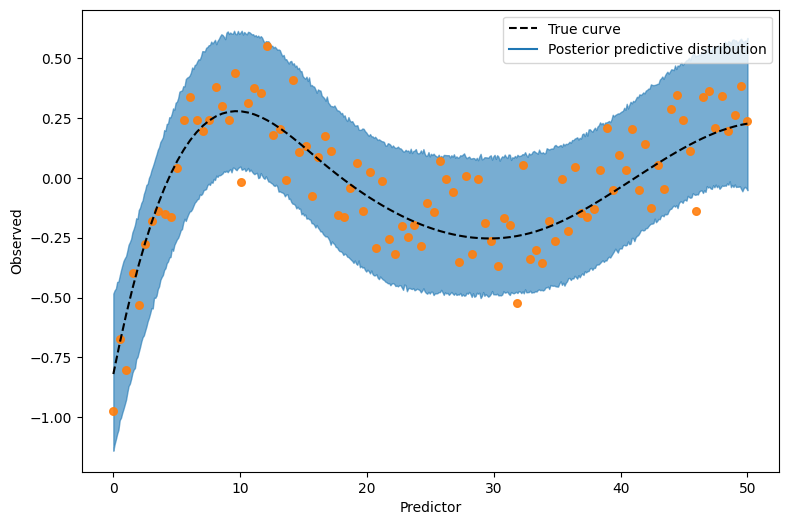

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

qts = np.quantile(pps, q=(0.025, 0.975), axis=0)

ax.fill_between(new_data["x"], qts[0], qts[1], color="C0", alpha=0.6)
ax.scatter(df["x"], df["y"], s=30, color="C1", alpha=0.9)
ax.plot(x, f, color="black", ls="--")
ax.set(xlabel="Predictor", ylabel="Observed");

handles = [Line2D([], [], color="black", ls="--"), Line2D([], [], color="C0")]
labels = ["True curve", "Posterior predictive distribution"]
ax.legend(handles, labels);

---

## HSGP by levels of a categorical covariate

In [10]:
data = pd.read_csv("gam_data.csv")
data["fac"] = pd.Categorical(data["fac"])
data.head()[["x2", "y", "fac"]]

,x2,y,fac
0,0.497183,3.085274,3
1,0.196003,-2.250410,2
2,0.958474,0.070548,3
3,0.972759,-0.230454,1
4,0.755836,2.173497,2


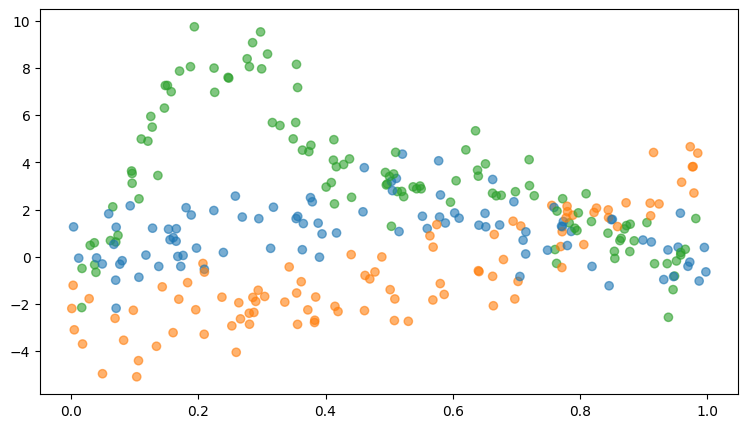

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6);

In [12]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=12, c=1.5)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=12, c=1.5)": "hsgp"})
model

       Formula: y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5)
        Family: gaussian
          Link: mu = identity
  Observations: 300
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x2, by=fac, m=12, c=1.5)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ Exponential(lam: 3.0)
        
        Auxiliary parameters
            y_sigma ~ HalfNormal(sigma: 1.0)

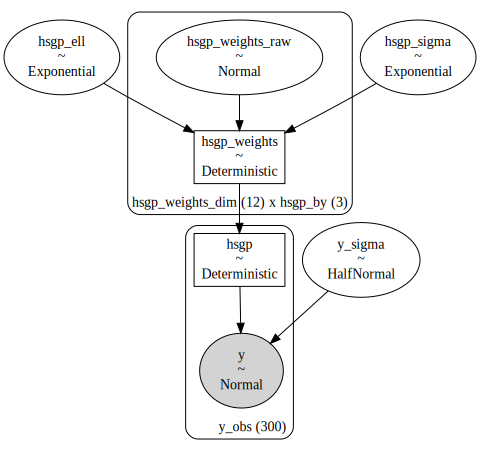

In [13]:
model.build()
model.graph()

In [14]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.95)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:03.823662
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.549645
Transforming variables...
Transformation time =  0:00:00.897110
0


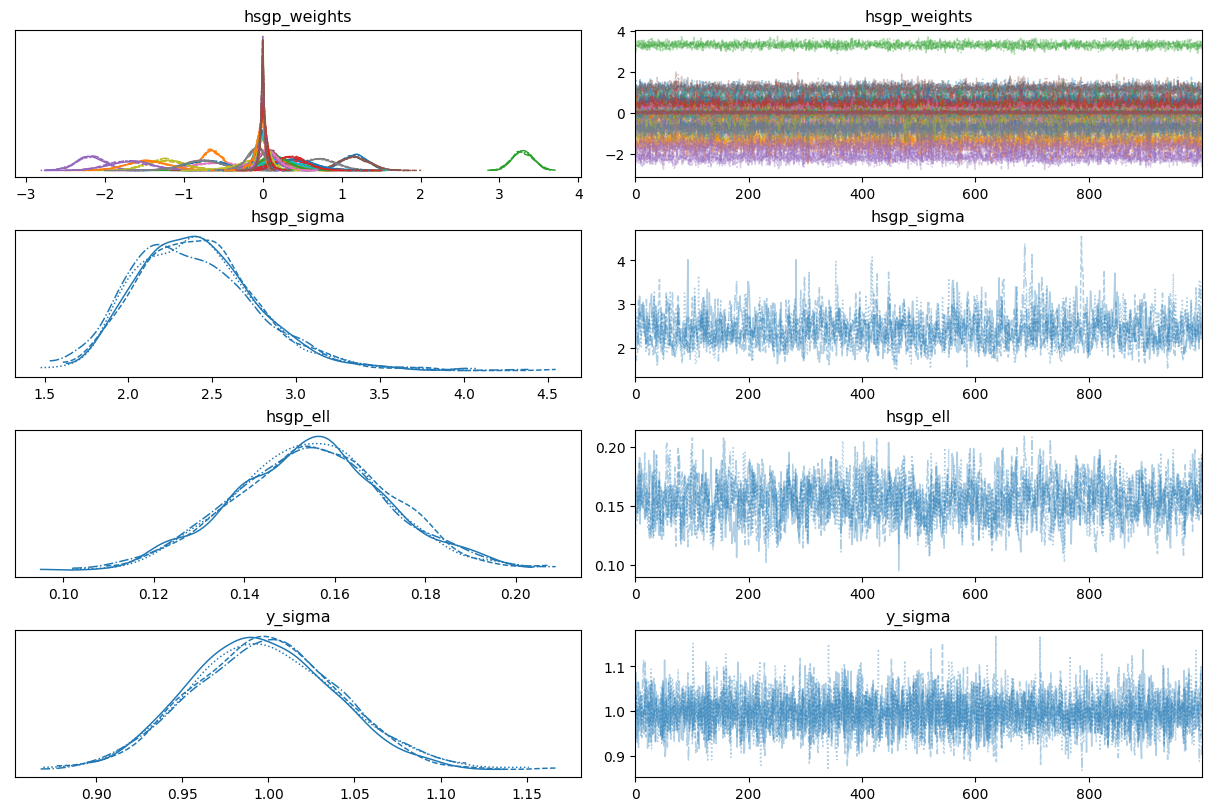

In [15]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

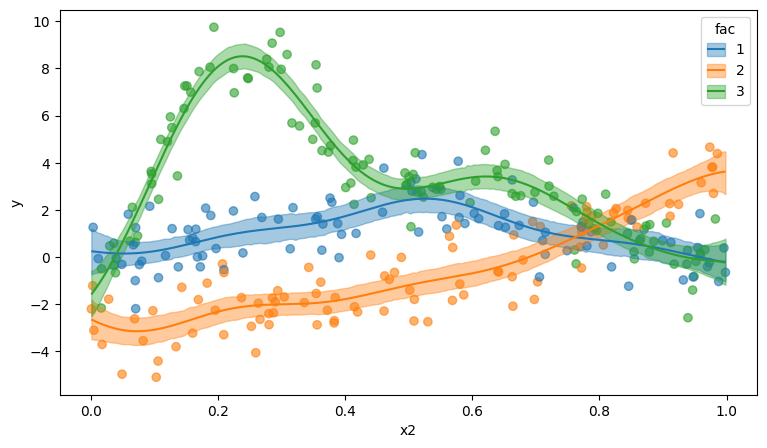

In [16]:
fig, ax = plt.subplots(figsize = (9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
plot_cap(model, idata, ["x2", "fac"], ax=ax);

Now use a different covariance functions for every group.

In [17]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)": "hsgp"})
model

       Formula: y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 300
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ Exponential(lam: 3.0)
        
        Auxiliary parameters
            y_sigma ~ HalfNormal(sigma: 1.0)

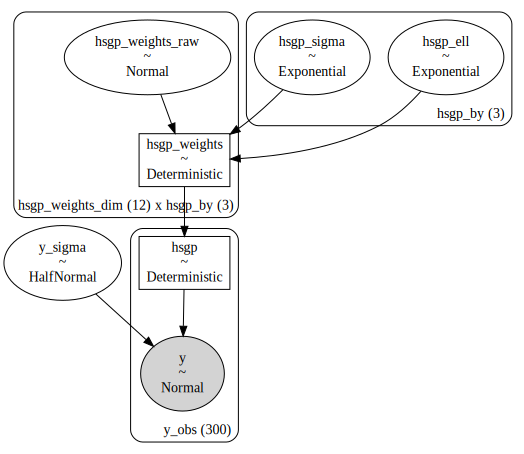

In [18]:
model.build()
model.graph()

In [19]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.95)

Compiling...
Compilation time =  0:00:04.132332
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:07.581241
Transforming variables...
Transformation time =  0:00:00.515377


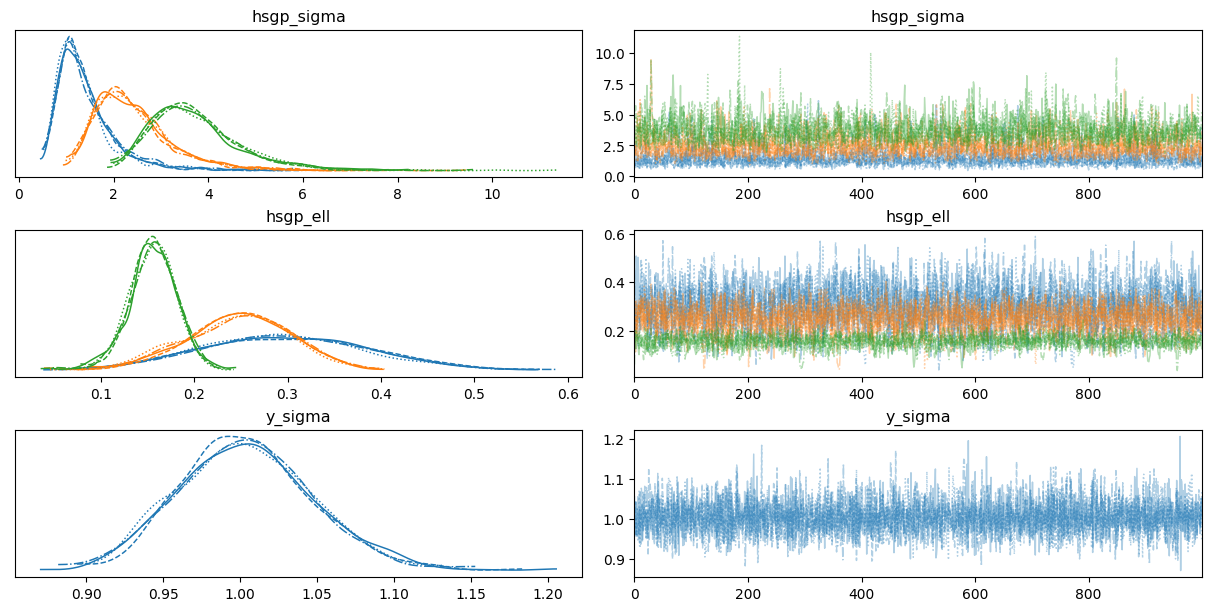

In [20]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

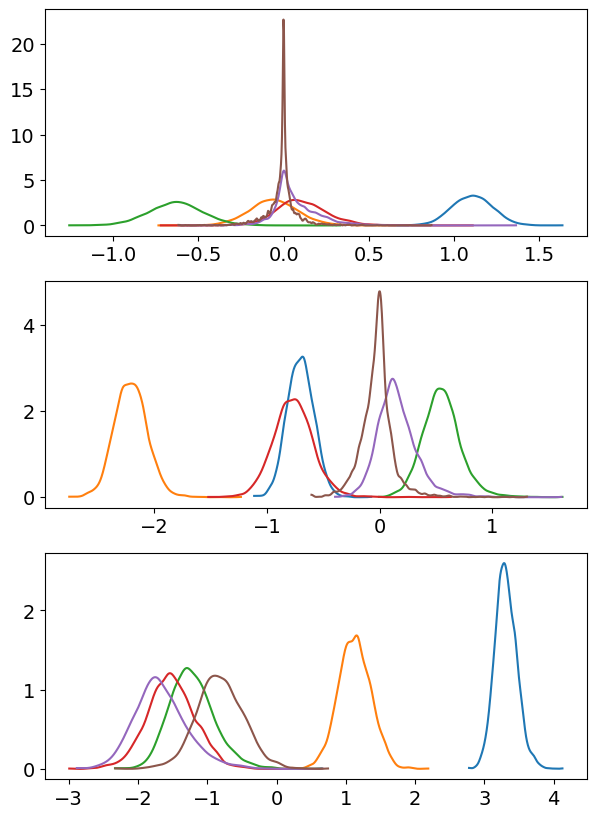

In [21]:
fig, axes = plt.subplots(3, 1, figsize = (7, 10))
for i in range(3):
    ax = axes[i]
    values = idata.posterior["hsgp_weights"].sel({"hsgp_by": i + 1})
    for j in range(6):
        az.plot_kde(
            values.sel({"hsgp_weights_dim": j}).to_numpy().flatten(), 
            ax=ax, 
            plot_kwargs={"color": f"C{j}"}
        );

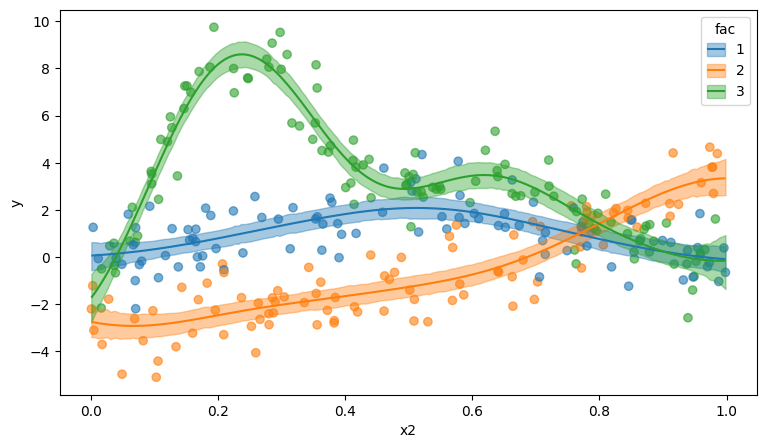

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
plot_cap(model, idata, ["x2", "fac"], ax=ax);